In [1]:
%load_ext autoreload
%autoreload 2

# Classification Task

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.fft import fft2, ifft2, fft, ifft

import torchvision.transforms as transforms
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from CNN import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [17]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Load MNIST Data

In [5]:
# capture a dictionary of hyperparameters with config
params = {
 # "dataset": "MNIST",
 # "machine": "desktop",
 # "model": "CNN -- 2 conv",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
}
wandb.config = params

In [6]:
# Compute MURA encoder and decoder
p = 23 # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

# define CNN and get data
model = CNN()
train_data, test_data = model._get_dataset(A)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 
PATH = f'../models/mnist_{params["epochs"]}epochs.pth'

In [7]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

## Train

In [10]:
wandb.(project="coded-aperture-MNIST", group="2_convolutions")
for epoch in range(params['epochs']):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        wandb.log({"epoch": epoch, "loss": running_loss})
print('Finished Training')
# Save model

torch.save(model.state_dict(), PATH)
wandb.finish()

[1,   100] loss: 0.112
[1,   200] loss: 0.080
[1,   300] loss: 0.052
[1,   400] loss: 0.040
[1,   500] loss: 0.032
[1,   600] loss: 0.030
[2,   100] loss: 0.026
[2,   200] loss: 0.024
[2,   300] loss: 0.021
[2,   400] loss: 0.021
[2,   500] loss: 0.018
[2,   600] loss: 0.016
[3,   100] loss: 0.017
[3,   200] loss: 0.015
[3,   300] loss: 0.015
[3,   400] loss: 0.014
[3,   500] loss: 0.015
[3,   600] loss: 0.014
[4,   100] loss: 0.012
[4,   200] loss: 0.012
[4,   300] loss: 0.012
[4,   400] loss: 0.012
[4,   500] loss: 0.012
[4,   600] loss: 0.012
[5,   100] loss: 0.011
[5,   200] loss: 0.011
[5,   300] loss: 0.010
[5,   400] loss: 0.011
[5,   500] loss: 0.011
[5,   600] loss: 0.012
[6,   100] loss: 0.011
[6,   200] loss: 0.010
[6,   300] loss: 0.010
[6,   400] loss: 0.009
[6,   500] loss: 0.010
[6,   600] loss: 0.009
[7,   100] loss: 0.009
[7,   200] loss: 0.010
[7,   300] loss: 0.009
[7,   400] loss: 0.010
[7,   500] loss: 0.009
[7,   600] loss: 0.009
[8,   100] loss: 0.009
[8,   200] 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▂▁▃▂▁▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁
epoch,49
loss,0.0


## Evaluate

In [8]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### One batch

In [11]:
# Define data iterator to get testing data in batches
dataiter = iter(loaders['test'])
images, labels = dataiter.next()

# Input image batch into model to get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

In [12]:
torch.nonzero(predicted != labels)

tensor([[18],
        [80]])

In [26]:
((predicted == labels) == False).nonzero()

/var/folders/00/mn_mr29n7s37xcf_4vdv1sc40000gn/T/ipykernel_5993/3193168444.py:1: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  ((predicted == labels) == False).nonzero()


tensor([[18],
        [80]])

### ALL test set

In [9]:
# Initialize variables
correct = 0
total = 0
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        # get images and labels from test set
        images, labels = data
    
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

Accuracy of the network on the 10000 test images: 95.35 %


## Confusion Matrix

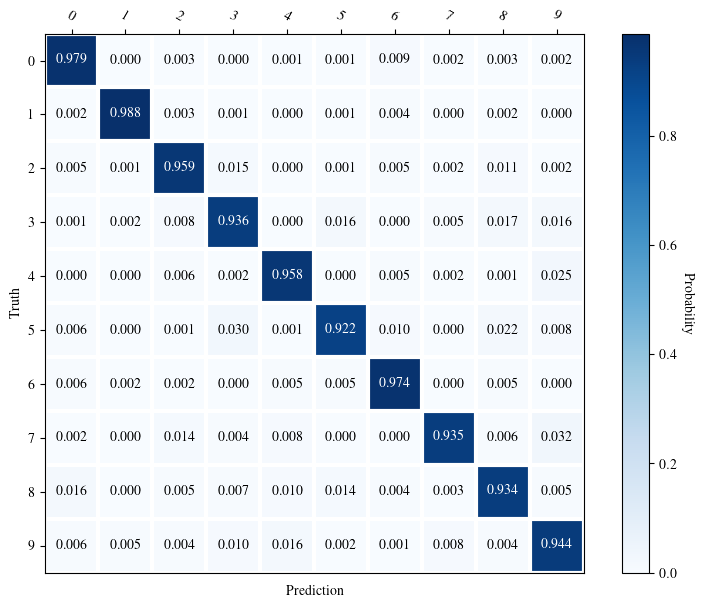

In [10]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [11]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

Accuracy for class:     0 is 97.857 %
Accuracy for class:     1 is 98.767 %
Accuracy for class:     2 is 95.930 %
Accuracy for class:     3 is 93.564 %
Accuracy for class:     4 is 95.825 %
Accuracy for class:     5 is 92.152 %
Accuracy for class:     6 is 97.390 %
Accuracy for class:     7 is 93.482 %
Accuracy for class:     8 is 93.429 %
Accuracy for class:     9 is 94.450 %


# Missclassifications

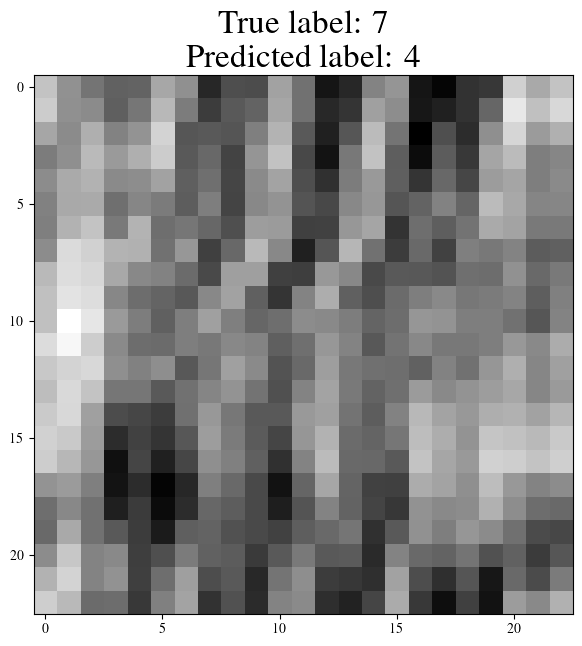

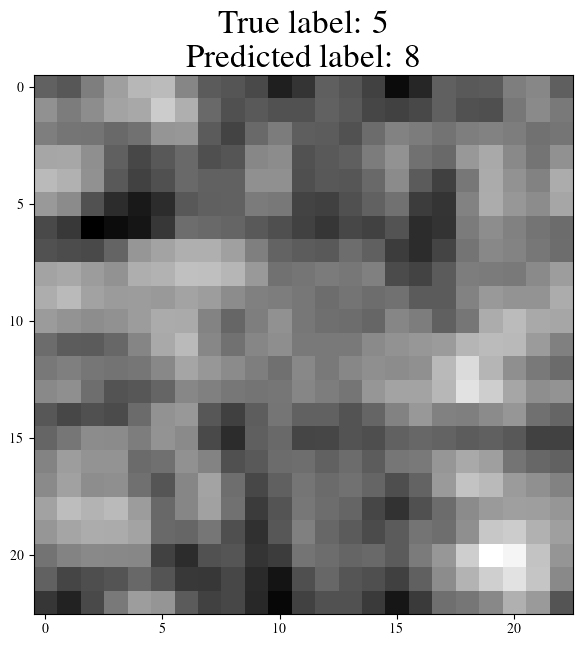

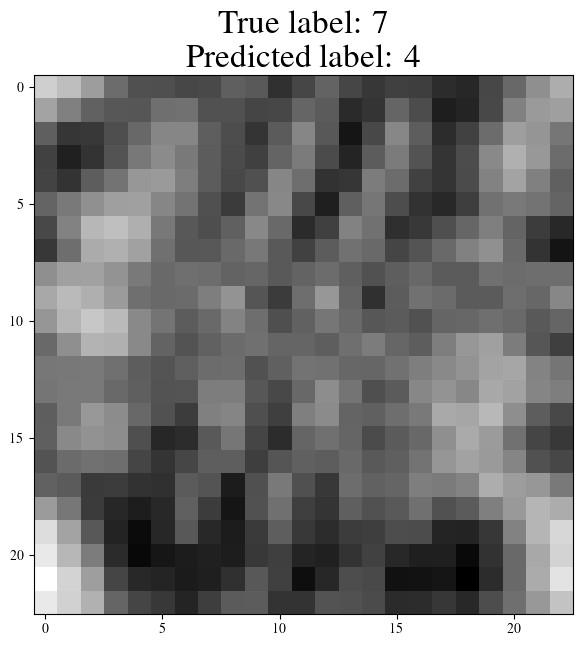

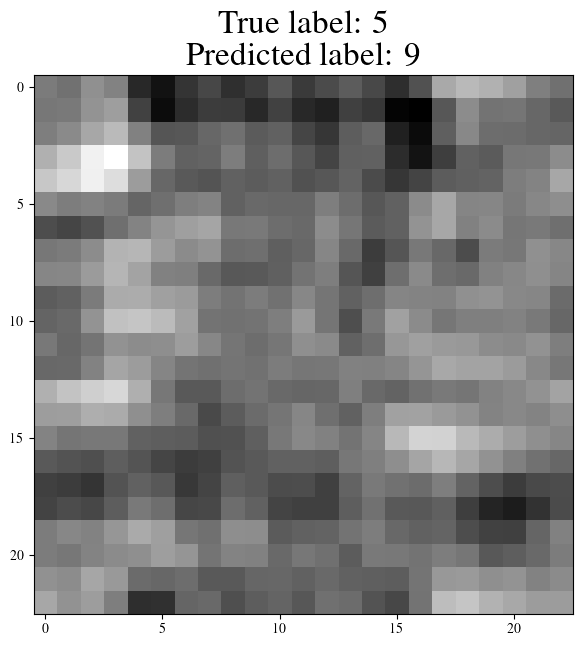

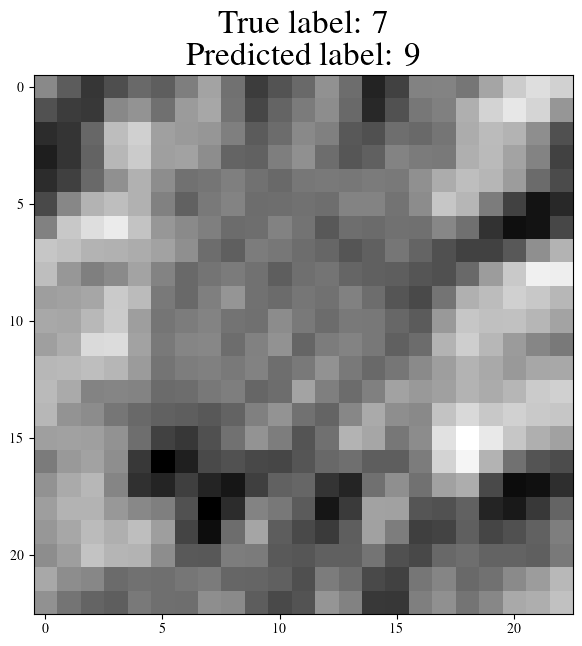

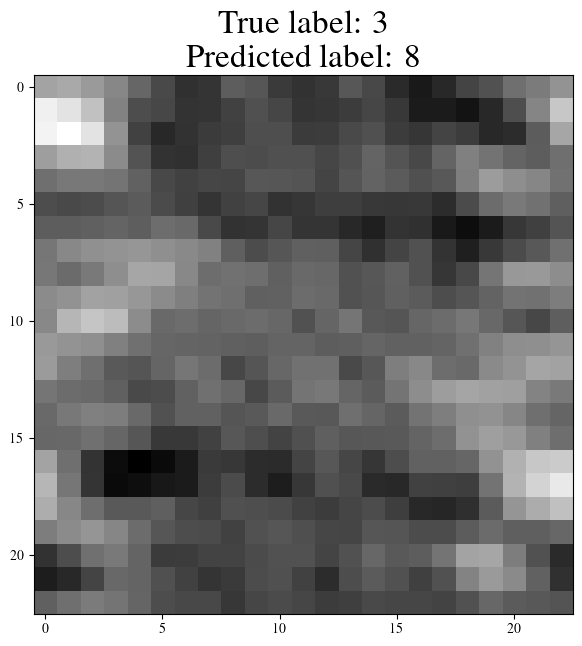

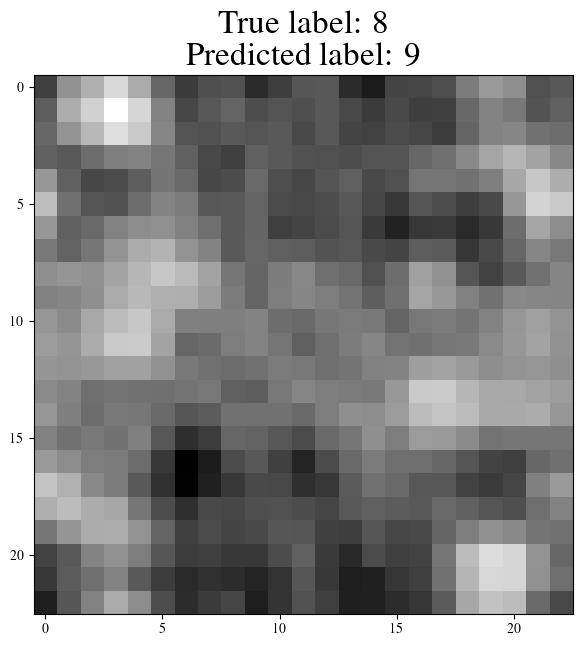

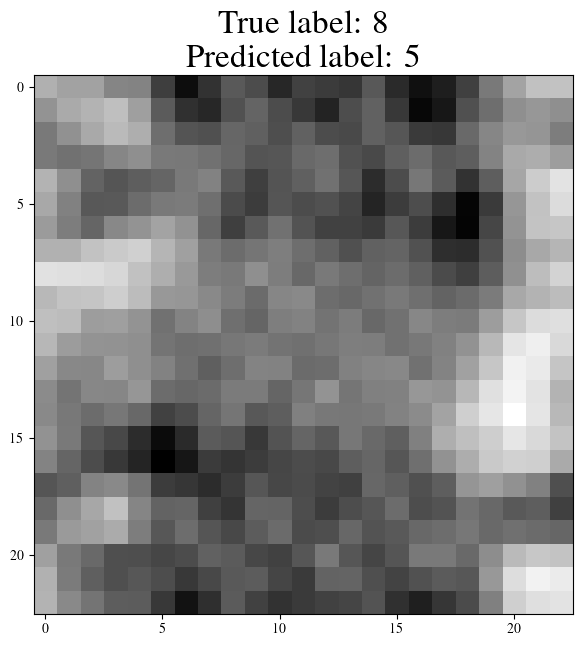

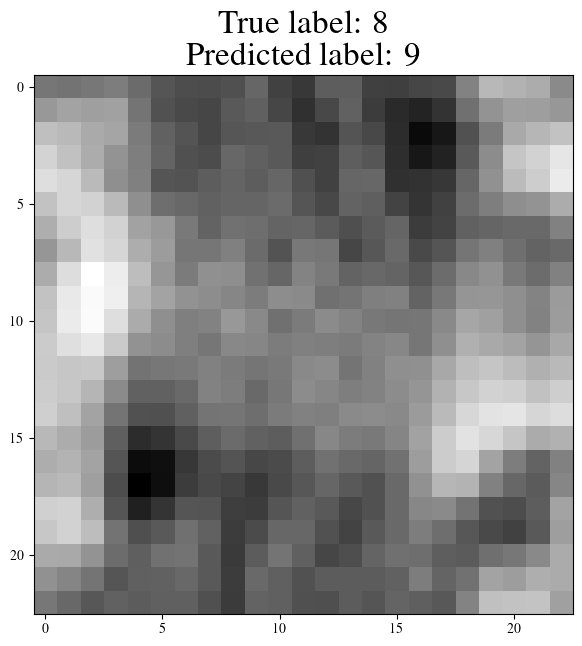

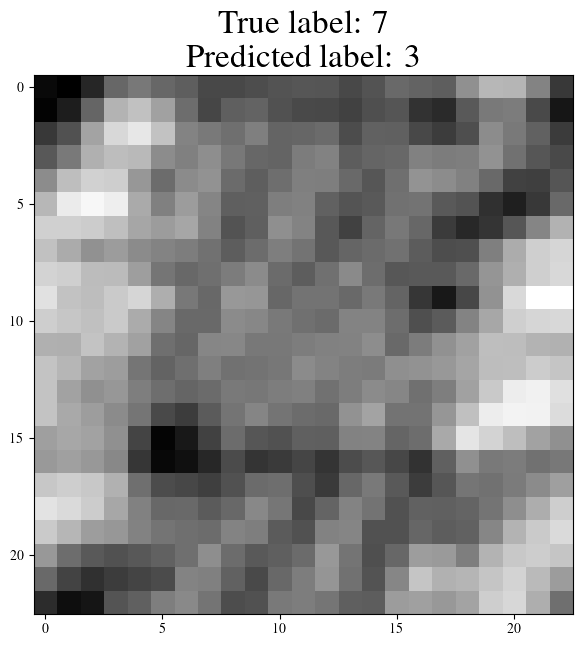

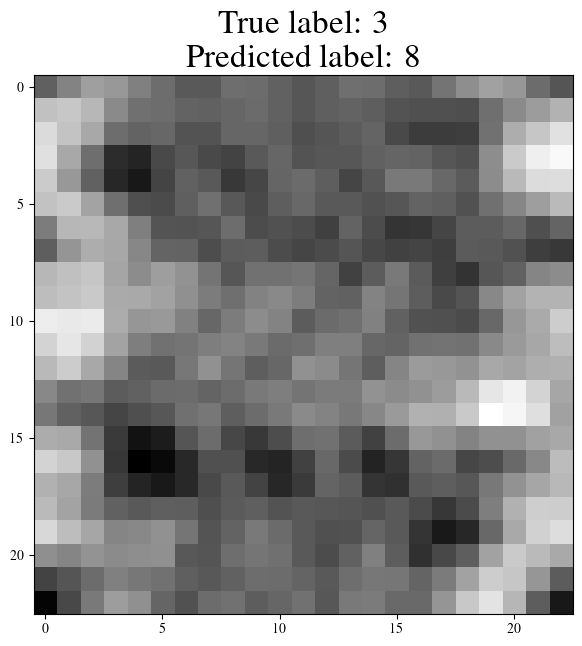

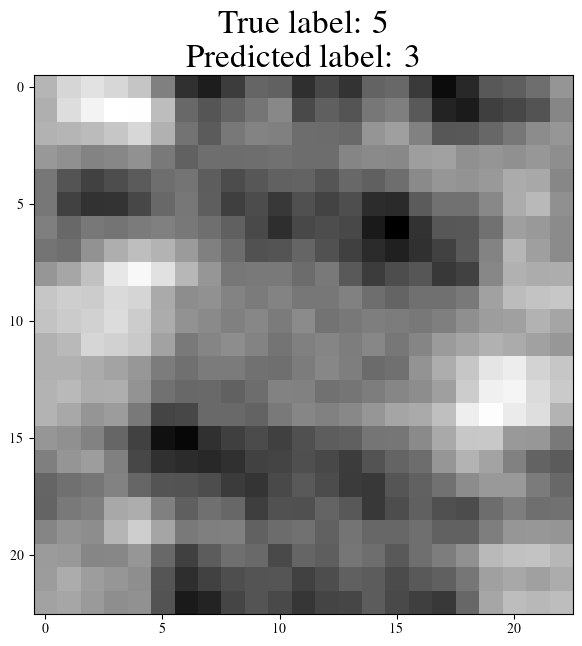

In [37]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        fig.savefig(FIG_FOLDER + f"misclass_encoded_{index}.png")
        plt.show() 

In [14]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
df.head()

,image_array,label,prediction
0,"[[46.441605, 51.616543, 53.98864, 54.621017, 5...",3,8
1,"[[29.652126, 33.823532, 33.88395, 27.97515, 26...",7,9
2,"[[19.68986, 17.479229, 20.025635, 21.90164, 24...",4,9
3,"[[25.181587, 20.707901, 18.937271, 19.943756, ...",4,6
4,"[[34.3612, 40.188046, 43.104168, 41.41689, 35....",8,0


In [15]:
df.label.value_counts(normalize=True)

5    0.150538
7    0.144086
3    0.139785
8    0.137634
9    0.120430
2    0.090323
4    0.088172
6    0.053763
0    0.045161
1    0.030108
Name: label, dtype: float64

In [27]:
df[df.label == 9].prediction.unique()

array([8, 3, 0, 4, 5, 7, 6, 1, 2])

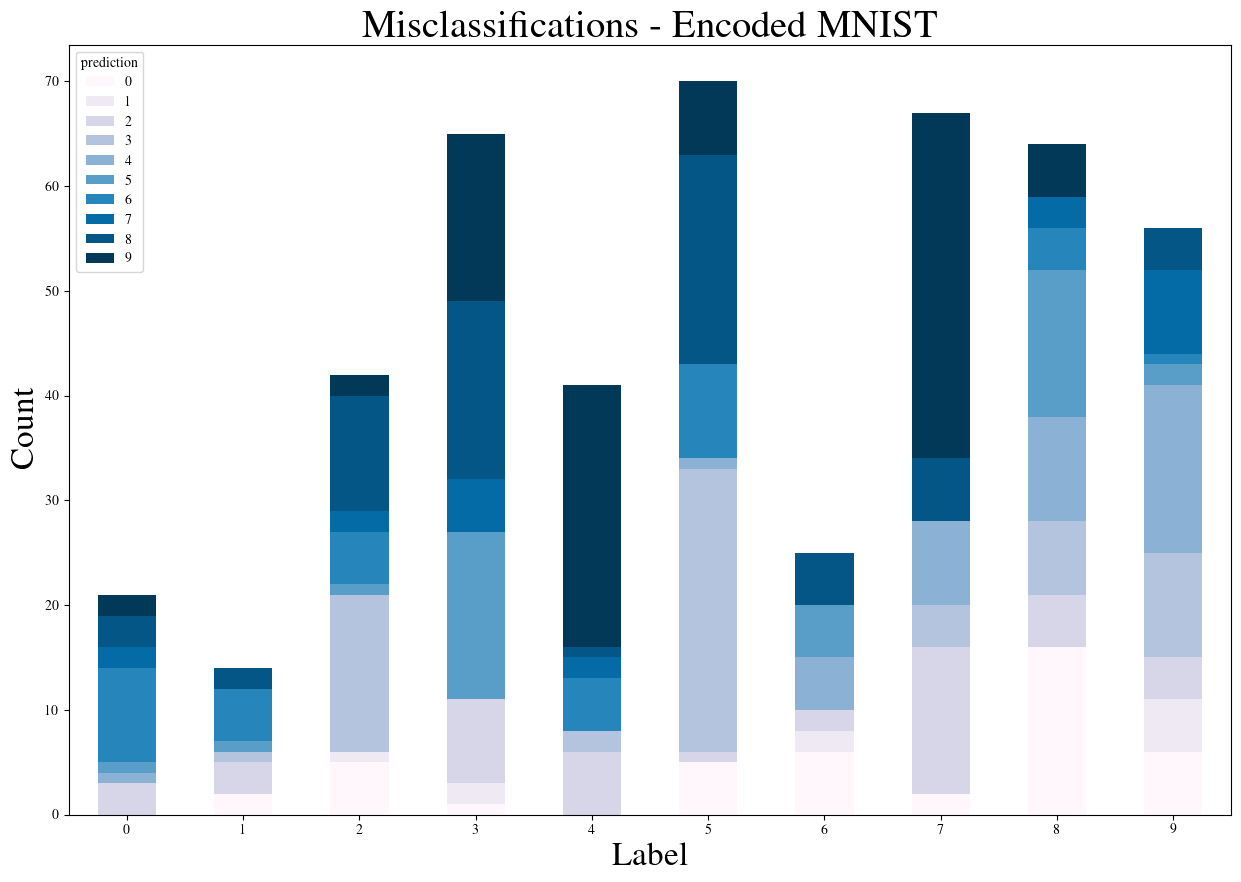

prediction   0  1   2   3   4   5  6  7   8   9
label                                          
0            0  0   3   0   1   1  9  2   3   2
1            2  0   3   1   0   1  5  0   2   0
2            5  1   0  15   0   1  5  2  11   2
3            1  2   8   0   0  16  0  5  17  16
4            0  0   6   2   0   0  5  2   1  25
5            5  0   1  27   1   0  9  0  20   7
6            6  2   2   0   5   5  0  0   5   0
7            2  0  14   4   8   0  0  0   6  33
8           16  0   5   7  10  14  4  3   0   5
9            6  5   4  10  16   2  1  8   4   0


In [23]:
fontsize = 28
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=fontsize-4)
plt.xlabel("Label", fontsize=fontsize-4)
plt.title("Misclassifications - Encoded MNIST", fontsize=fontsize)
#plt.savefig("../figs/misclassifications_counts_encoded_mnist.png")
plt.show()
print(crosstab_misclass)

# Plotting/other

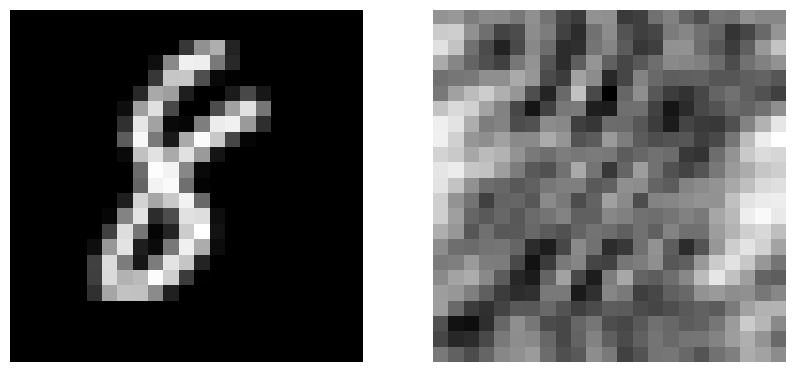

In [133]:
cmap = "gray"
index = 0
img = images[index][0]
true_img = mura.FFT_convolve(img.numpy(), G)
pred_lab = predicted[index]
true_lab = labels[index]

fig, axs = plt.subplots(1,2, figsize=(10,7))
axs = axs.ravel()

axs[0].imshow(true_img, cmap=cmap);
axs[1].imshow(img, cmap=cmap)

axs[0].axis('off') ; axs[1].axis('off')
#plt.savefig("../figs/true_img_coded_img_8.svg")
plt.show()

# To be deleted